# Content

+ Data Cleaning
+ Exploratory Visualization
+ Feature Engineering
+ Basic Modeling & Evaluation
+ Hyperparameters tuning
+ Ensemble Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
# combine train and test set.
train=pd.read_csv('E:/Workspace/Titanic/train.csv')
test=pd.read_csv('E:/Workspace/Titanic/test.csv')
full=pd.concat([train,test],ignore_index=True)

In [4]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# Data Cleaning

In [5]:
full.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

__The 'Age', 'Cabin', 'Embarked', 'Fare' columns have missing values. First we fill the missing 'Embarked' with the mode.__

In [6]:
full.Embarked.mode()

0    S
dtype: object

In [7]:
full['Embarked'].fillna('S',inplace=True)

__Since 'Fare' is mainly related to 'Pclass', we should check which class this person belongs to.__

In [8]:
full[full.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


__It's a passenger from Pclass 3, so we'll fill the missing value with the median fare of Pclass 3.__

In [9]:
full.Fare.fillna(full[full.Pclass==3]['Fare'].median(),inplace=True)

**There are a lot of missing values in 'Cabin', maybe there is difference between the survival rate of people who has Cabin number and those who hasn't.**

In [10]:
full.loc[full.Cabin.notnull(),'Cabin']=1
full.loc[full.Cabin.isnull(),'Cabin']=0

In [11]:
full.Cabin.isnull().sum()

0

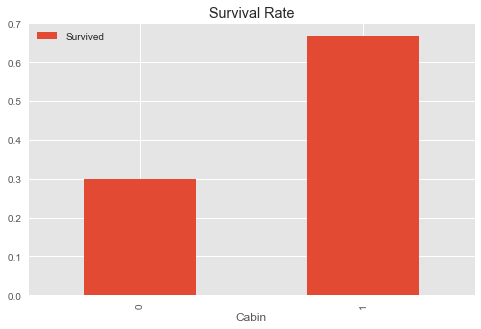

In [12]:
pd.pivot_table(full,index=['Cabin'],values=['Survived']).plot.bar(figsize=(8,5))
plt.title('Survival Rate')

__We can also plot the count of 'Cabin' to see some patterns.__

In [13]:
cabin=pd.crosstab(full.Cabin,full.Survived)
cabin.rename(index={0:'no cabin',1:'cabin'},columns={0.0:'Dead',1.0:'Survived'},inplace=True)
cabin

Survived,Dead,Survived
Cabin,,
no cabin,481,206
cabin,68,136


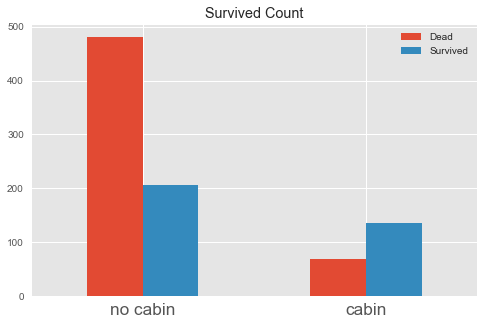

In [14]:
cabin.plot.bar(figsize=(8,5))
plt.xticks(rotation=0,size='xx-large')
plt.title('Survived Count')
plt.xlabel('')
plt.legend()

__From the plot, we can conclude that there is far more chance for a passenger to survive if we know his/her 'Cabin'.__

### Extract Title from 'Name'

In [15]:
full['Title']=full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [16]:
full.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
the Countess      1
Don               1
Lady              1
Sir               1
Jonkheer          1
Dona              1
Capt              1
Name: Title, dtype: int64

In [17]:
pd.crosstab(full.Title,full.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


__All the 'Title' belongs to one kind of gender except for 'Dr'.__

In [18]:
full[(full.Title=='Dr')&(full.Sex=='female')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
796,49.0,1,S,25.9292,"Leader, Dr. Alice (Farnham)",0,797,1,female,0,1.0,17465,Dr


__So the PassengerId of the female 'Dr' is '797'. Then we map the 'Title'.__

In [19]:
nn={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}

In [20]:
full.Title=full.Title.map(nn)

In [21]:
# assign the female 'Dr' to 'Rarewoman'
full.loc[full.PassengerId==797,'Title']='Rarewoman'

In [22]:
full.Title.value_counts()

Mr           765
Miss         260
Mrs          197
Master        61
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

In [23]:
full[full.Title=='Master']['Sex'].value_counts()

male    61
Name: Sex, dtype: int64

In [24]:
full[full.Title=='Master']['Age'].describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

In [25]:
full[full.Title=='Miss']['Age'].describe()

count    210.000000
mean      21.774238
std       12.249077
min        0.170000
25%       15.000000
50%       22.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

+ __'Master' mainly stands for little boy, but we also want to find little girl. Because children tend to have higher survival rate.__

+ __For the 'Miss' with a Age record, we can simply determine whether a 'Miss' is a little girl by her age.__

+ __For the 'Miss' with no Age record, we use (Parch!=0). Since if it's a little girl, she was very likely to be accompanied by parents.__

We'll create a function to filter the girls. The function can't be used if 'Age' is Nan, so first we fill the missing values with '999'.

In [26]:
full.Age.fillna(999,inplace=True)

In [27]:
def girl(aa):
    if (aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif (aa.Age==999)&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title

In [28]:
full['Title']=full.apply(girl,axis=1)

In [29]:
full.Title.value_counts()

Mr           765
Miss         201
Mrs          197
Master        61
Girl          59
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

__Next we fill the missing 'Age' according to their 'Title'.__

In [30]:
full[full.Age==999]['Age'].value_counts()

999.0    263
Name: Age, dtype: int64

In [31]:
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    full.loc[(full.Age==999)&(full.Title==i),'Age']=full.loc[full.Title==i,'Age'].median()

In [32]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


### Finally, there is no missing value now!!!

# Exploratory Visualization

In [33]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,1,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


__Let's first check whether the Age of each Title is reasonable.__

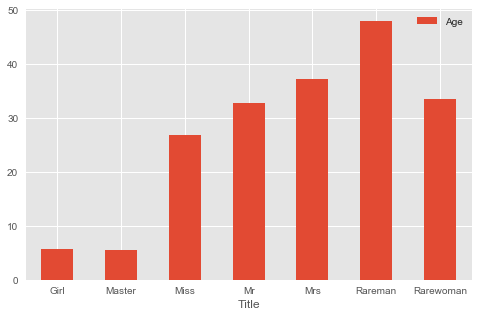

In [34]:
full.groupby(['Title'])[['Age','Title']].mean().plot(kind='bar',figsize=(8,5))
plt.xticks(rotation=0)
plt.show()

__As we can see, female has a much larger survival rate than male.__

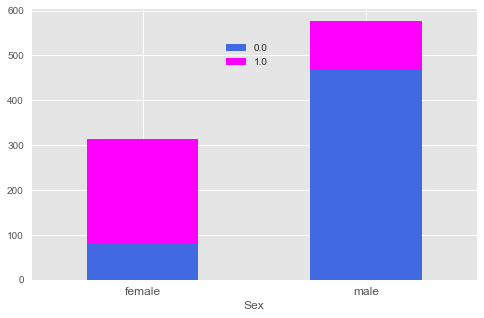

In [35]:
pd.crosstab(full.Sex,full.Survived).plot.bar(stacked=True,figsize=(8,5),color=['#4169E1','#FF00FF'])
plt.xticks(rotation=0,size='large')
plt.legend(bbox_to_anchor=(0.55,0.9))

__ We can also check the relationship between 'Age' and 'Survived'.__

In [36]:
agehist=pd.concat([full[full.Survived==1]['Age'],full[full.Survived==0]['Age']],axis=1)
agehist.columns=['Survived','Dead']
agehist.head()

,Survived,Dead
0,NaN,22.0
1,38.0,NaN
2,26.0,NaN
3,35.0,NaN
4,NaN,35.0


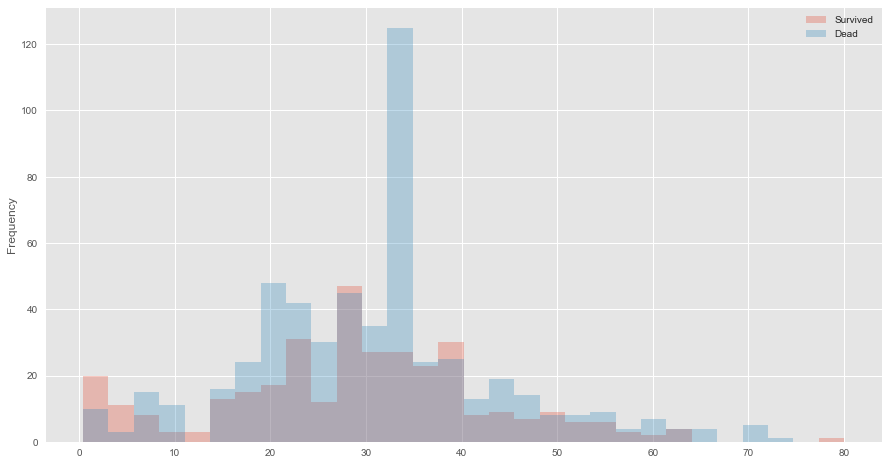

In [37]:
agehist.plot(kind='hist',bins=30,figsize=(15,8),alpha=0.3)

In [38]:
farehist=pd.concat([full[full.Survived==1]['Fare'],full[full.Survived==0]['Fare']],axis=1)
farehist.columns=['Survived','Dead']
farehist.head()

,Survived,Dead
0,NaN,7.25
1,71.2833,NaN
2,7.9250,NaN
3,53.1000,NaN
4,NaN,8.05


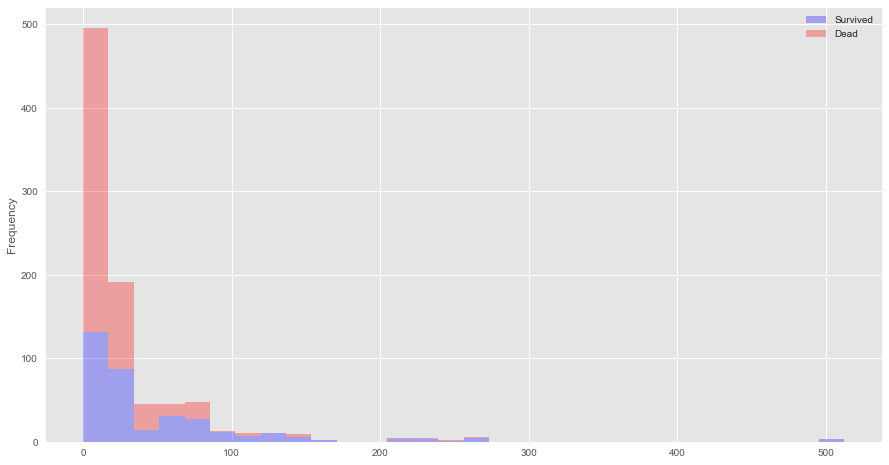

In [39]:
farehist.plot.hist(bins=30,figsize=(15,8),alpha=0.3,stacked=True,color=['blue','red'])

__People with high 'Fare' are more likely to survive, though most 'Fare' are under 100.__

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

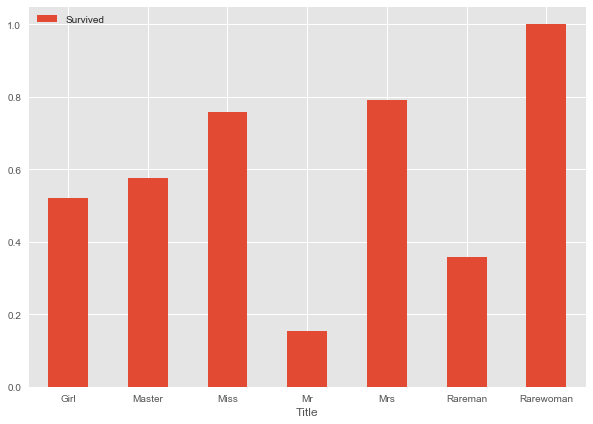

In [40]:
full.groupby(['Title'])[['Title','Survived']].mean().plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=0)

__The 'Rarewoman' has 100% survival rate, that's amazing!!__

__It's natural to assume that 'Pclass' also plays a big part, as we can see from the plot below. The females in class 3 have a survival rate of about 50%, while survival rateof females from class1/2 are much higher.__

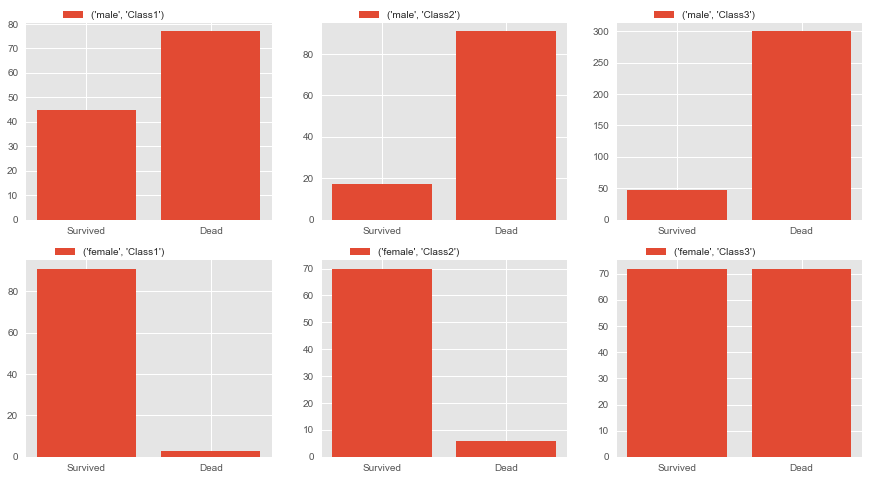

In [41]:
fig,axes=plt.subplots(2,3,figsize=(15,8))
Sex1=['male','female']
for i,ax in zip(Sex1,axes):
    for j,pp in zip(range(1,4),ax):
        PclassSex=full[(full.Sex==i)&(full.Pclass==j)]['Survived'].value_counts().sort_index(ascending=False)
        pp.bar(range(len(PclassSex)),PclassSex,label=(i,'Class'+str(j)))
        pp.set_xticks((0,1))
        pp.set_xticklabels(('Survived','Dead'))
        pp.legend(bbox_to_anchor=(0.6,1.1))

# Feature Engeneering

In [42]:
# create age bands
full.AgeCut=pd.cut(full.Age,5)

In [43]:
# create fare bands
full.FareCut=pd.qcut(full.Fare,5)

In [44]:
full.AgeCut.value_counts().sort_index()

(0.0902, 16.136]    152
(16.136, 32.102]    564
(32.102, 48.068]    473
(48.068, 64.034]    107
(64.034, 80]         13
Name: Age, dtype: int64

In [45]:
full.FareCut.value_counts().sort_index()

[0, 7.854]           275
(7.854, 10.5]        255
(10.5, 21.558]       255
(21.558, 41.579]     265
(41.579, 512.329]    259
Name: Fare, dtype: int64

In [46]:
# replace agebands with ordinals
full.loc[full.Age<=16.136,'AgeCut']=1
full.loc[(full.Age>16.136)&(full.Age<=32.102),'AgeCut']=2
full.loc[(full.Age>32.102)&(full.Age<=48.068),'AgeCut']=3
full.loc[(full.Age>48.068)&(full.Age<=64.034),'AgeCut']=4
full.loc[full.Age>64.034,'AgeCut']=5

In [47]:
full.loc[full.Fare<=7.854,'FareCut']=1
full.loc[(full.Fare>7.854)&(full.Fare<=10.5),'FareCut']=2
full.loc[(full.Fare>10.5)&(full.Fare<=21.558),'FareCut']=3
full.loc[(full.Fare>21.558)&(full.Fare<=41.579),'FareCut']=4
full.loc[full.Fare>41.579,'FareCut']=5

__We can see from the plot that 'FareCut' has a big impact on survial rate.__

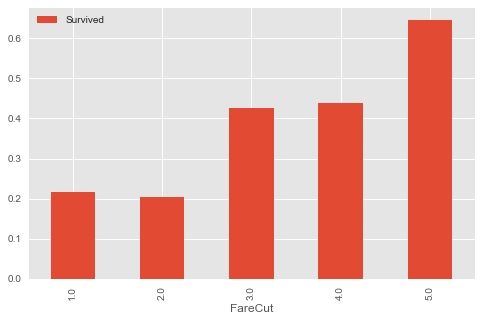

In [48]:
full[['FareCut','Survived']].groupby(['FareCut']).mean().plot.bar(figsize=(8,5))

In [49]:
full.corr()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,AgeCut,FareCut
Age,1.000000,0.153051,-0.161843,0.026528,-0.361790,-0.259798,-0.077692,0.939760,0.129070
Fare,0.153051,1.000000,0.221668,0.031029,-0.558740,0.160388,0.257307,0.135191,0.603698
Parch,-0.161843,0.221668,1.000000,0.008942,0.018322,0.373587,0.081629,-0.159184,0.337256
PassengerId,0.026528,0.031029,0.008942,1.000000,-0.038354,-0.055224,-0.005007,0.017900,-0.003346
Pclass,-0.361790,-0.558740,0.018322,-0.038354,1.000000,0.060832,-0.338481,-0.328087,-0.720881
SibSp,-0.259798,0.160388,0.373587,-0.055224,0.060832,1.000000,-0.035322,-0.256077,0.351834
Survived,-0.077692,0.257307,0.081629,-0.005007,-0.338481,-0.035322,1.000000,-0.103700,0.318206
AgeCut,0.939760,0.135191,-0.159184,0.017900,-0.328087,-0.256077,-0.103700,1.000000,0.091607
FareCut,0.129070,0.603698,0.337256,-0.003346,-0.720881,0.351834,0.318206,0.091607,1.000000


__We haven't gererate any feature from 'Parch','Pclass','SibSp','Title', so let's do this by using pivot table.__

In [50]:
full[full.Survived.notnull()].pivot_table(index=['Title','Pclass'],values=['Survived']).sort_values('Survived',ascending=False)

Survived
Title     Pclass          
Rarewoman 2       1.000000
          1       1.000000
Master    1       1.000000
          2       1.000000
Girl      2       1.000000
Miss      1       0.977273
Mrs       1       0.976190
Miss      2       0.920000
Mrs       2       0.902439
Miss      3       0.552239
Mrs       3       0.500000
Girl      1       0.500000
Rareman   1       0.416667
Girl      3       0.400000
Master    3       0.392857
Mr        1       0.345794
          3       0.112853
          2       0.082474
Rareman   2       0.000000

In [51]:
full[full.Survived.notnull()].pivot_table(index=['Title','Parch'],values=['Survived']).sort_values('Survived',ascending=False)

Survived
Title     Parch          
Rarewoman 0      1.000000
Master    0      1.000000
Miss      1      0.875000
          2      0.857143
Mrs       0      0.855072
          1      0.812500
          2      0.769231
          3      0.750000
Girl      0      0.750000
Miss      0      0.736842
Girl      1      0.650000
Master    1      0.608696
          2      0.500000
Rareman   0      0.384615
Girl      2      0.363636
Mrs       5      0.250000
Mr        0      0.157447
          1      0.147059
          2      0.133333
          4      0.000000
          5      0.000000
Mrs       4      0.000000
          6      0.000000
Rareman   1      0.000000
Mr        3      0.000000

#### _From the pivot tables above, there is definitely a relationship among 'Survived','Title','Pclass','Parch'. So we can combine them together._

In [52]:
# only choose the object with not null 'Survived'.
TPP=full[full.Survived.notnull()].pivot_table(index=['Title','Pclass','Parch'],values=['Survived']).sort_values('Survived',ascending=False)
TPP

Survived
Title     Pclass Parch          
Rarewoman 2      0      1.000000
Master    3      0      1.000000
Mrs       1      1      1.000000
          2      2      1.000000
                 3      1.000000
Miss      2      2      1.000000
                 1      1.000000
          1      2      1.000000
Mrs       1      0      1.000000
Miss      1      1      1.000000
Girl      2      1      1.000000
Master    2      2      1.000000
                 1      1.000000
          1      2      1.000000
Rarewoman 1      0      1.000000
Girl      2      2      1.000000
Miss      1      0      0.966667
Mrs       2      1      0.909091
Miss      2      0      0.904762
Mrs       2      0      0.869565
Girl      3      0      0.750000
Mrs       3      2      0.666667
                 0      0.611111
Miss      3      0      0.571429
Girl      3      1      0.533333
Mrs       1      2      0.500000
          3      3      0.500000
Girl      1      2      0.500000
Rareman   1      0      0.454545
Mrs       3      1      0.444444
Master    3      1      0.437500
Mr        1      2      0.400000
                 0      0.352273
Miss      3      2      0.333333
Mr        1      1      0.307692
Master    3      2      0.272727
Mrs       3      5      0.250000
Girl      3      2      0.187500
Mr        3      0      0.118644
          2      0      0.091954
          3      1      0.071429
          1      4      0.000000
Miss      3      1      0.000000
Mr        2      2      0.000000
          3      5      0.000000
Mrs       3      4      0.000000
Mr        3      4      0.000000
Mrs       3      6      0.000000
Mr        3      3      0.000000
Rareman   1      1      0.000000
          2      0      0.000000
Mr        3      2      0.000000
          2      1      0.000000

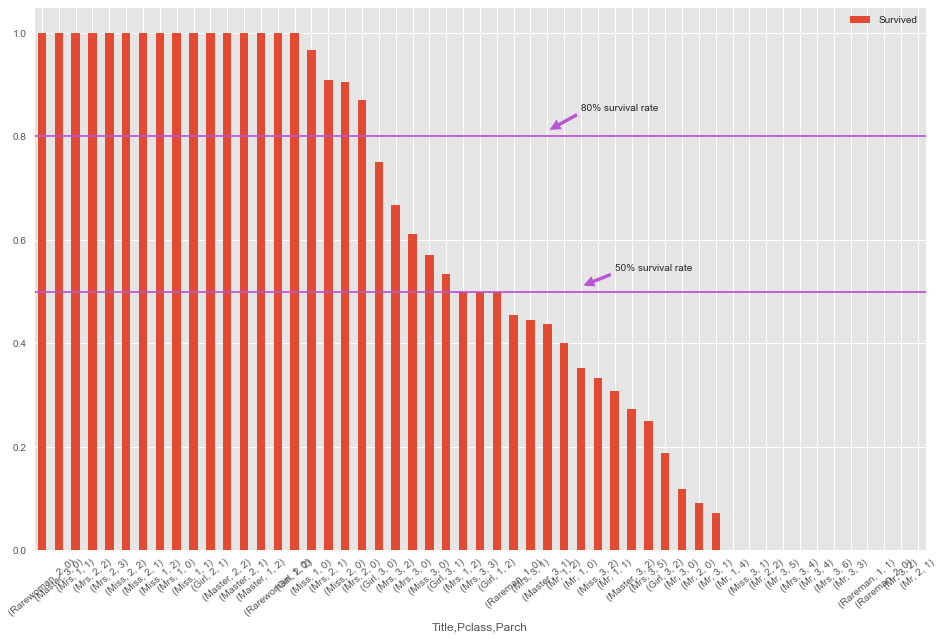

In [53]:
TPP.plot(kind='bar',figsize=(16,10))
plt.xticks(rotation=40)
plt.axhline(0.8,color='#BA55D3')
plt.axhline(0.5,color='#BA55D3')
plt.annotate('80% survival rate',xy=(30,0.81),xytext=(32,0.85),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.annotate('50% survival rate',xy=(32,0.51),xytext=(34,0.54),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))

__From the plot, we can draw some horizontal lines and make some classification. I only choose 80% and 50%, because I'm so afraid of overfitting.__

In [54]:
# use 'Title','Pclass','Parch' to generate feature 'TPP'.
Tit=['Girl','Master','Mr','Miss','Mrs','Rareman','Rarewoman']
for i in Tit:
    for j in range(1,4):
        for g in range(0,10):
            if full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g)&(full.Survived.notnull()),'Survived'].mean()>=0.8:
                full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g),'TPP']=1
            elif full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g)&(full.Survived.notnull()),'Survived'].mean()>=0.5:
                full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g),'TPP']=2
            elif full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g)&(full.Survived.notnull()),'Survived'].mean()>=0:
                full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g),'TPP']=3
            else: 
                full.loc[(full.Title==i)&(full.Pclass==j)&(full.Parch==g),'TPP']=4

+ __'TPP=1' means highest probability to survive, and 'TPP=3' means the lowest.__
+ __'TPP=4' means there is no such combination of (Title&Pclass&Pclass) in train set. Let's see what kind of combination it contains.__

In [55]:
full[full.TPP==4]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,AgeCut,FareCut,TPP
915,48.0,1,C,262.375,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",3,916,1,female,1,NaN,PC 17608,Mrs,3.0,5.0,4.0
960,60.0,1,S,263.000,"Fortune, Mrs. Mark (Mary McDougald)",4,961,1,female,1,NaN,19950,Mrs,4.0,5.0,4.0
979,33.0,0,Q,7.750,"O'Donoghue, Ms. Bridget",0,980,3,female,0,NaN,364856,Rarewoman,3.0,1.0,4.0
1011,12.0,0,S,15.750,"Watt, Miss. Bertha J",0,1012,2,female,0,NaN,C.A. 33595,Girl,1.0,3.0,4.0
1030,40.0,0,S,46.900,"Goodwin, Mr. Charles Frederick",6,1031,3,male,1,NaN,CA 2144,Mr,3.0,5.0,4.0
1033,61.0,1,C,262.375,"Ryerson, Mr. Arthur Larned",3,1034,1,male,1,NaN,PC 17608,Mr,4.0,5.0,4.0
1233,34.5,0,S,69.550,"Sage, Mr. John George",9,1234,3,male,1,NaN,CA. 2343,Mr,3.0,5.0,4.0
1256,39.0,0,S,69.550,"Sage, Mrs. John (Annie Bullen)",9,1257,3,female,1,NaN,CA. 2343,Mrs,3.0,5.0,4.0


__ We can simply classify them by 'Sex'&'Pclass'.__

In [56]:
full.ix[(full.TPP==4)&(full.Sex=='female')&(full.Pclass!=3),'TPP']=1
full.ix[(full.TPP==4)&(full.Sex=='female')&(full.Pclass==3),'TPP']=2
full.ix[(full.TPP==4)&(full.Sex=='male')&(full.Pclass!=3),'TPP']=2
full.ix[(full.TPP==4)&(full.Sex=='male')&(full.Pclass==3),'TPP']=3

In [57]:
full.TPP.value_counts()

3.0    870
1.0    262
2.0    177
Name: TPP, dtype: int64

In [58]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
AgeCut         1309 non-null float64
FareCut        1309 non-null float64
TPP            1309 non-null float64
dtypes: float64(6), int64(4), object(6)
memory usage: 163.7+ KB


# Basic Modeling & Evaluation

In [59]:
predictors=['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Title','AgeCut','TPP','FareCut','Age','Fare']

In [60]:
# convert categorical variables to numerical variables
full_dummies=pd.get_dummies(full[predictors])

In [61]:
full_dummies.head()

,Parch,Pclass,SibSp,AgeCut,TPP,FareCut,Age,Fare,Cabin_0,Cabin_1,...,Embarked_S,Sex_female,Sex_male,Title_Girl,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rareman,Title_Rarewoman
0,0,3,1,2.0,3.0,1.0,22.0,7.2500,1,0,...,1,0,1,0,0,0,1,0,0,0
1,0,1,1,3.0,1.0,5.0,38.0,71.2833,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,3,0,2.0,2.0,2.0,26.0,7.9250,1,0,...,1,1,0,0,0,1,0,0,0,0
3,0,1,1,3.0,1.0,5.0,35.0,53.1000,0,1,...,1,1,0,0,0,0,0,1,0,0
4,0,3,0,3.0,3.0,2.0,35.0,8.0500,1,0,...,1,0,1,0,0,0,1,0,0,0


__We choose 7 models and use 5-folds cross-calidation to evaluate these models.__

Models include:

+ k-Nearest Neighbors
+ Logistic Regression
+ Naive Bayes classifier
+ Decision Tree
+ Random Forrest
+ Gradient Boosting Decision Tree
+ Support Vector Machine

In [62]:
from sklearn.model_selection import cross_val_score

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [64]:
models=[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),
       GradientBoostingClassifier(),SVC()]

In [65]:
full.shape,full_dummies.shape

((1309, 16), (1309, 22))

In [66]:
X=full_dummies[:891]
y=full.Survived[:891]
test_X=full_dummies[891:]

__As some algorithms such as KNN and SVM are sensitive to the scaling of the data, here we also apply standard-scaling to the data.__

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
scaler=StandardScaler()
X_scaled=scaler.fit(X).transform(X)
test_X_scaled=scaler.fit(X).transform(test_X)

In [69]:
# evaluate models by using cross-validation
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    score=cross_val_score(model,X,y,cv=5)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.722876869778,[ 0.68156425  0.7150838   0.73033708  0.73033708  0.75706215]
LR:0.831672250422,[ 0.83798883  0.82681564  0.80337079  0.83707865  0.85310734]
NB:0.810311027039,[ 0.83798883  0.81005587  0.79775281  0.78089888  0.82485876]
Tree:0.785673102259,[ 0.7877095   0.75418994  0.84269663  0.75280899  0.79096045]
RF:0.800204518994,[ 0.79888268  0.81005587  0.84269663  0.75842697  0.79096045]
GDBT:0.841822627028,[ 0.8547486   0.80446927  0.86516854  0.80337079  0.88135593]
SVM:0.747564940189,[ 0.72067039  0.73184358  0.76404494  0.73595506  0.78531073]


In [70]:
# used scaled data
names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
for name, model in zip(names,models):
    score=cross_val_score(model,X_scaled,y,cv=5)
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.808133025651,[ 0.81564246  0.78212291  0.79775281  0.80898876  0.83615819]
LR:0.832833650201,[ 0.82681564  0.81564246  0.8258427   0.83146067  0.86440678]
NB:0.800337117662,[ 0.75418994  0.79888268  0.82022472  0.7752809   0.85310734]
Tree:0.782302315742,[ 0.78212291  0.75977654  0.8258427   0.75280899  0.79096045]
RF:0.812589532472,[ 0.82681564  0.7877095   0.85393258  0.7752809   0.81920904]
GDBT:0.841822627028,[ 0.8547486   0.80446927  0.86516854  0.80337079  0.88135593]
SVM:0.833944833422,[ 0.83798883  0.82681564  0.83146067  0.79775281  0.87570621]


__'k-Nearest Neighbors', 'Support Vector Machine' perform much better on scaled data__

**Then we use (feature importances) in GradientBoostingClassifier to see which features are important.**

In [71]:
model=GradientBoostingClassifier()

In [72]:
model.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [73]:
model.feature_importances_

array([  8.23873192e-03,   1.55330255e-02,   4.23491355e-02,
         1.73248767e-02,   1.58137778e-01,   7.00455031e-03,
         2.81746705e-01,   3.56681604e-01,   1.31821169e-02,
         1.31893025e-02,   2.71040896e-03,   2.88669758e-04,
         1.50828689e-02,   4.70109269e-04,   2.09220151e-03,
         3.74471722e-03,   1.81631536e-02,   4.23201420e-03,
         2.76442479e-02,   1.04389872e-02,   1.74479529e-03,
         0.00000000e+00])

In [74]:
X.columns

Index([u'Parch', u'Pclass', u'SibSp', u'AgeCut', u'TPP', u'FareCut', u'Age',
       u'Fare', u'Cabin_0', u'Cabin_1', u'Embarked_C', u'Embarked_Q',
       u'Embarked_S', u'Sex_female', u'Sex_male', u'Title_Girl',
       u'Title_Master', u'Title_Miss', u'Title_Mr', u'Title_Mrs',
       u'Title_Rareman', u'Title_Rarewoman'],
      dtype='object')

In [75]:
fi=pd.DataFrame({'importance':model.feature_importances_},index=X.columns)

In [76]:
fi.sort_values('importance',ascending=False)

,importance
Fare,0.356682
Age,0.281747
TPP,0.158138
SibSp,0.042349
Title_Mr,0.027644
Title_Master,0.018163
AgeCut,0.017325
Pclass,0.015533
Embarked_S,0.015083
Cabin_1,0.013189


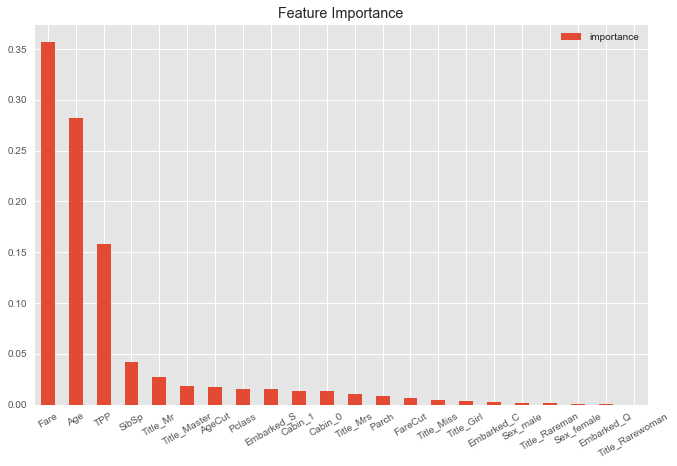

In [77]:
fi.sort_values('importance',ascending=False).plot.bar(figsize=(11,7))
plt.xticks(rotation=30)
plt.title('Feature Importance',size='x-large')

__Based on the bar plot, 'TPP','Fare','Age' are the most important.__

**Now let's think through this problem in another way. Our goal here is to improve the overall accuracy. This is equivalent to minimizing the misclassified observations. So if all the misclassified observations are found, maybe we can see the pattern and generate some new features.**

**Again we use cross-validation to search for the miscalssified observations**

In [78]:
from sklearn.model_selection import KFold

In [79]:
kf=KFold(n_splits=10,random_state=1)

In [80]:
kf.get_n_splits(X)

10

In [81]:
print(kf)

KFold(n_splits=10, random_state=1, shuffle=False)


In [82]:
# extract the indices of misclassified observations
rr=[]
for train_index, val_index in kf.split(X):
    pred=model.fit(X.ix[train_index],y[train_index]).predict(X.ix[val_index])
    rr.append(y[val_index][pred!=y[val_index]].index.values)

In [83]:
rr

[array([ 2, 14, 17, 18, 21, 23, 25, 30, 36, 38, 40, 41, 49, 55, 68, 74, 79,
        81, 85], dtype=int64),
 array([106, 107, 111, 114, 127, 137, 139, 140, 141, 142, 146, 165, 169, 177], dtype=int64),
 array([184, 187, 199, 204, 205, 207, 209, 220, 224, 226, 233, 235, 240,
        246, 248, 251, 261, 264, 267], dtype=int64),
 array([271, 273, 279, 283, 286, 288, 297, 301, 312, 315, 328, 330, 338,
        347, 351], dtype=int64),
 array([357, 361, 390, 391, 396, 400, 414, 415, 429, 431, 444], dtype=int64),
 array([447, 449, 452, 453, 455, 460, 483, 489, 501, 502, 505, 507, 509,
        510, 534], dtype=int64),
 array([536, 543, 547, 550, 553, 554, 569, 570, 578, 579, 587, 604, 607,
        617, 621, 622], dtype=int64),
 array([630, 632, 643, 645, 647, 649, 654, 659, 660, 664, 673, 677, 680,
        692, 698, 711, 712], dtype=int64),
 array([729, 744, 748, 762, 767, 772, 782], dtype=int64),
 array([804, 807, 816, 821, 828, 839, 852, 854, 855, 857], dtype=int64)]

In [84]:
# combine all the indices
whole_index=np.concatenate(rr)
len(whole_index)

143

In [85]:
full.ix[whole_index].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,AgeCut,FareCut,TPP
2,26.0,0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,2.0,2.0,2.0
14,14.0,0,S,7.8542,"Vestrom, Miss. Hulda Amanda Adolfina",0,15,3,female,0,0.0,350406,Girl,1.0,2.0,2.0
17,34.5,0,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373,Mr,3.0,3.0,3.0
18,31.0,0,S,18.0000,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",0,19,3,female,1,0.0,345763,Mrs,2.0,3.0,2.0
21,34.0,1,S,13.0000,"Beesley, Mr. Lawrence",0,22,2,male,0,1.0,248698,Mr,3.0,3.0,3.0


In [86]:
diff=full.ix[whole_index]

In [87]:
diff.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,AgeCut,FareCut,TPP
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,30.867133,25.823951,0.265734,403.167832,2.335664,0.426573,0.643357,2.426573,2.958042,2.608392
std,12.678160,28.147027,0.691508,248.636308,0.887662,0.773592,0.480692,0.782642,1.331494,0.581825
min,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,23.500000,7.925000,0.000000,202.500000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,30.000000,15.245800,0.000000,397.000000,3.000000,0.000000,1.000000,2.000000,3.000000,3.000000
75%,37.000000,29.700000,0.000000,620.000000,3.000000,1.000000,1.000000,3.000000,4.000000,3.000000
max,80.000000,151.550000,5.000000,858.000000,3.000000,4.000000,1.000000,5.000000,5.000000,3.000000


In [88]:
diff.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket,Title
count,143,143,143,143,143,143
unique,2,3,143,2,131,6
top,0,S,"Pickard, Mr. Berk (Berk Trembisky)",male,1601,Mr
freq,105,102,1,86,5,77


In [89]:
# both mean and count of 'survived' should be considered.
diff.groupby(['Title'])['Survived'].agg([('average','mean'),('number','count')])

,average,number
Title,,
Girl,0.333333,6
Master,1.000000,3
Miss,0.333333,30
Mr,0.831169,77
Mrs,0.428571,21
Rareman,0.666667,6


In [90]:
diff.groupby(['Title','Pclass'])['Survived'].agg([('average','mean'),('number','count')])

average  number
Title   Pclass                  
Girl    1       0.000000       1
        3       0.400000       5
Master  3       1.000000       3
Miss    1       0.000000       1
        2       0.000000       2
        3       0.370370      27
Mr      1       0.656250      32
        2       0.888889       9
        3       0.972222      36
Mrs     2       0.000000       4
        3       0.529412      17
Rareman 1       0.666667       6

**It seems mainly the third class 'Miss'/'Mrs' and the first/third class 'Mr' are missclassified.**

In [91]:
diff.groupby(['Title','Pclass','Parch','SibSp'])['Survived'].agg([('average','mean'),('number','count')])

average  number
Title   Pclass Parch SibSp                  
Girl    1      2     1      0.000000       1
        3      0     0      0.000000       1
               1     0      0.000000       1
                     1      0.000000       1
               2     0      1.000000       1
                     4      1.000000       1
Master  3      1     1      1.000000       1
               2     0      1.000000       1
                     4      1.000000       1
Miss    1      0     0      0.000000       1
        2      0     0      0.000000       2
        3      0     0      0.380952      21
                     1      0.000000       3
                     2      0.500000       2
               2     4      1.000000       1
Mr      1      0     0      0.705882      17
                     1      0.625000       8
               1     0      0.000000       1
                     1      0.666667       3
               2     0      0.500000       2
                     1      1.000000       1
        2      0     0      1.000000       7
                     1      0.500000       2
        3      0     0      0.968750      32
                     1      1.000000       2
                     2      1.000000       1
               1     1      1.000000       1
Mrs     2      0     0      0.000000       1
                     1      0.000000       2
               1     1      0.000000       1
        3      0     0      0.500000       2
                     1      0.375000       8
                     3      1.000000       1
               1     0      1.000000       1
                     1      0.666667       3
               2     0      0.000000       1
               5     1      1.000000       1
Rareman 1      0     0      0.600000       5
                     2      1.000000       1

Gererally, we should only pick the categories with relatively large numbers. That is:

1. **'Mr','Pclass 1','Parch 0','SibSp 0', 17**
2. **'Mr','Pclass 1','Parch 0','SibSp 1', 8**
3. **'Mr','Pclass 2/3','Parch 0','SibSp 0', 32+7**
4. **'Miss','Pclass 3','Parch 0','SibSp 0', 21**

__Then we add new feature 'MPPS'.__

In [92]:
full.loc[(full.Title=='Mr')&(full.Pclass==1)&(full.Parch==0)&((full.SibSp==0)|(full.SibSp==1)),'MPPS']=1
full.loc[(full.Title=='Mr')&(full.Pclass!=1)&(full.Parch==0)&(full.SibSp==0),'MPPS']=2
full.loc[(full.Title=='Miss')&(full.Pclass==3)&(full.Parch==0)&(full.SibSp==0),'MPPS']=3
full.MPPS.fillna(4,inplace=True)

In [93]:
full.MPPS.value_counts()

4.0    606
2.0    485
1.0    132
3.0     86
Name: MPPS, dtype: int64

From the __feature-Importance__ plot we can see the 'Fare' is the most important feature, let's explore whether we can generate some new feature.

In [94]:
diff[(diff.Title=='Mr')|(diff.Title=='Miss')].groupby(['Title','Survived','Pclass'])[['Fare']].describe().unstack()

Fare                                                    \
                      count       mean        std      min       25%      50%   
Title Survived Pclass                                                           
Miss  0.0      1        1.0  28.712500        NaN  28.7125  28.71250  28.7125   
               2        2.0  13.000000   0.000000  13.0000  13.00000  13.0000   
               3       17.0   9.564712   3.410307   6.7500   7.75000   7.8542   
      1.0      3       10.0   9.999590   4.904273   7.5500   7.75625   7.8896   
Mr    0.0      1       11.0  60.678027  35.887886  26.5500  29.85000  53.1000   
               2        1.0  27.720800        NaN  27.7208  27.72080  27.7208   
               3        1.0  56.495800        NaN  56.4958  56.49580  56.4958   
      1.0      1       21.0  51.167862  30.466921  26.5500  26.55000  35.5000   
               2        8.0  14.107812   4.963091  10.5000  12.37500  13.0000   
               3       35.0  14.217260  15.845064   0.0000   7.77500   7.9250   

                                            
                             75%       max  
Title Survived Pclass                       
Miss  0.0      1       28.712500   28.7125  
               2       13.000000   13.0000  
               3        8.662500   18.0000  
      1.0      3        9.362525   23.2500  
Mr    0.0      1       94.050000  113.2750  
               2       27.720800   27.7208  
               3       56.495800   56.4958  
      1.0      1       76.729200  120.0000  
               2       13.215625   26.0000  
               3        9.081250   56.4958

In [95]:
full[(full.Title=='Mr')|(full.Title=='Miss')].groupby(['Title','Survived','Pclass'])[['Fare']].describe().unstack()

Fare                                            \
                       count        mean         std      min      25%   
Title Survived Pclass                                                    
Miss  0.0      1         1.0   28.712500         NaN  28.7125  28.7125   
               2         2.0   13.000000    0.000000  13.0000  13.0000   
               3        30.0   11.637643    8.512399   6.7500   7.7750   
      1.0      1        43.0  126.099126   92.270616  26.2833  77.1250   
               2        23.0   17.611230   12.193091  10.5000  12.1750   
               3        37.0    9.216559    4.004733   7.2250   7.7500   
Mr    0.0      1        70.0   65.164104   61.918723   0.0000  28.8000   
               2        89.0   19.651638   15.857649   0.0000  11.5000   
               3       283.0   10.779237    9.170363   0.0000   7.7333   
      1.0      1        37.0   73.464646  109.590302  26.2875  26.5500   
               2         8.0   14.107812    4.963091  10.5000  12.3750   
               3        36.0   15.391664   17.133150   0.0000   7.7750   

                                                      
                           50%         75%       max  
Title Survived Pclass                                 
Miss  0.0      1       28.7125   28.712500   28.7125  
               2       13.0000   13.000000   13.0000  
               3        8.4000   10.346900   46.9000  
      1.0      1       90.0000  152.506250  512.3292  
               2       13.0000   17.429150   65.0000  
               3        7.7750    7.925000   24.1500  
Mr    0.0      1       48.3021   78.459375  263.0000  
               2       13.0000   26.000000   73.5000  
               3        7.8958    8.662500   69.5500  
      1.0      1       35.5000   76.729200  512.3292  
               2       13.0000   13.215625   26.0000  
               3        7.9250    9.500000   56.4958

But there seems no big difference between the 'Fare' of 'diff' and 'full'.

__Finally we could draw a corrlelation heatmap__

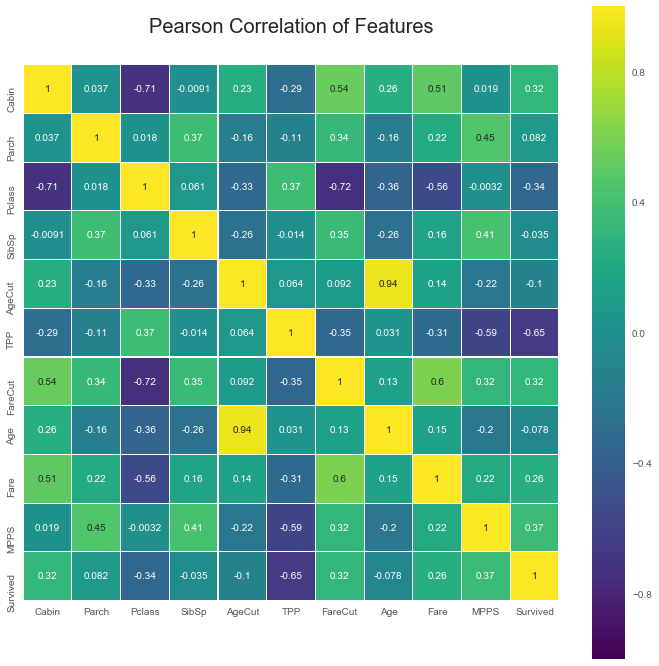

In [96]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(full[['Cabin','Parch','Pclass','SibSp','AgeCut','TPP','FareCut','Age','Fare','MPPS','Survived']].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Hyperparameters Tuning

__Now let's do grid search for some algorithms. Since many algorithms performs better in scaled data, we will use scaled data.__

In [97]:
predictors=['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Title','AgeCut','TPP','FareCut','Age','Fare','MPPS']
full_dummies=pd.get_dummies(full[predictors])
X=full_dummies[:891]
y=full.Survived[:891]
test_X=full_dummies[891:]

scaler=StandardScaler()
X_scaled=scaler.fit(X).transform(X)
test_X_scaled=scaler.fit(X).transform(test_X)

In [98]:
from sklearn.model_selection import GridSearchCV

### k-Nearest Neighbors

In [99]:
param_grid={'n_neighbors':[1,2,3,4,5,6,7,8,9]}
grid_search=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'n_neighbors': 8}, 0.8271604938271605)

### Logistic Regression

In [100]:
param_grid={'C':[0.01,0.1,1,10]}
grid_search=GridSearchCV(LogisticRegression(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 0.1}, 0.83052749719416386)

In [101]:
# second round grid search
param_grid={'C':[0.04,0.06,0.08,0.1,0.12,0.14]}
grid_search=GridSearchCV(LogisticRegression(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 0.06}, 0.83277216610549942)

### Support Vector Machine

In [102]:
param_grid={'C':[0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 10, 'gamma': 0.01}, 0.83164983164983164)

In [103]:
#second round grid search
param_grid={'C':[2,4,6,8,10,12,14],'gamma':[0.008,0.01,0.012,0.015,0.02]}
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'C': 4, 'gamma': 0.015}, 0.83501683501683499)

### Gradient Boosting Decision Tree

In [104]:
param_grid={'n_estimators':[30,50,80,120,200],'learning_rate':[0.05,0.1,0.5,1],'max_depth':[1,2,3,4,5]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 120},
 0.84399551066217737)

In [105]:
#second round search
param_grid={'n_estimators':[100,120,140,160],'learning_rate':[0.05,0.08,0.1,0.12],'max_depth':[3,4]}
grid_search=GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5)

grid_search.fit(X_scaled,y)

grid_search.best_params_,grid_search.best_score_

({'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 100},
 0.85072951739618408)

# Ensemble Methods 

## Bagging

__We use logistic regression with the parameter we just tuned to apply bagging.__

In [106]:
from sklearn.ensemble import BaggingClassifier

In [107]:
bagging=BaggingClassifier(LogisticRegression(C=0.06),n_estimators=100)

## VotingClassifier

__We use five models to apply votingclassifier, namely logistic regression, random forest, gradient boosting decision,support vector machine and k-nearest neighbors.__

In [108]:
from sklearn.ensemble import VotingClassifier

In [109]:
clf1=LogisticRegression(C=0.06)
clf2=RandomForestClassifier(n_estimators=500)
clf3=GradientBoostingClassifier(n_estimators=120,learning_rate=0.12,max_depth=4)
clf4=SVC(C=4,gamma=0.015,probability=True)
clf5=KNeighborsClassifier(n_neighbors=8)

In [110]:
eclf_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)])

In [111]:
# add weights
eclfW_hard=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],weights=[1,1,2,2,1])

In [112]:
# soft voting
eclf_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft')

In [113]:
# add weights
eclfW_soft=VotingClassifier(estimators=[('LR',clf1),('RF',clf2),('GDBT',clf3),('SVM',clf4),('KNN',clf5)],voting='soft',weights=[1,1,2,2,1])

__Finally we can evaluate all the models we just used.__

In [114]:
models=[KNeighborsClassifier(n_neighbors=8),LogisticRegression(C=0.06),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=500),
        GradientBoostingClassifier(n_estimators=120,learning_rate=0.12,max_depth=4),SVC(C=4,gamma=0.015),
        eclf_hard,eclf_soft,eclfW_hard,eclfW_soft,bagging]

In [115]:
names=['KNN','LR','NB','CART','RF','GBT','SVM','VC_hard','VC_soft','VCW_hard','VCW_soft','Bagging']
for name,model in zip(names,models):
    score=cross_val_score(model,X_scaled,y,cv=5)
    print("{}: {},{}".format(name,score.mean(),score))

KNN: 0.827196415899,[ 0.84916201  0.77653631  0.87078652  0.80898876  0.83050847]
LR: 0.832814818992,[ 0.84357542  0.81564246  0.81460674  0.8258427   0.86440678]
NB: 0.801460784095,[ 0.75977654  0.79888268  0.81460674  0.7752809   0.85875706]
CART: 0.791240650446,[ 0.7877095   0.78212291  0.84831461  0.76404494  0.7740113 ]
RF: 0.799150325893,[ 0.81564246  0.75977654  0.84831461  0.75280899  0.81920904]
GBT: 0.850748336665,[ 0.87150838  0.82122905  0.88202247  0.82022472  0.85875706]
SVM: 0.83505580386,[ 0.84357542  0.82681564  0.83146067  0.80337079  0.8700565 ]
VC_hard: 0.845168163411,[ 0.84357542  0.82681564  0.87640449  0.80898876  0.8700565 ]
VC_soft: 0.839562740023,[ 0.84357542  0.81564246  0.86516854  0.80337079  0.8700565 ]
VCW_hard: 0.847402800282,[ 0.84916201  0.83240223  0.87640449  0.80898876  0.8700565 ]
VCW_soft: 0.838432867447,[ 0.83798883  0.82681564  0.85393258  0.80337079  0.8700565 ]
Bagging: 0.83058018212,[ 0.83798883  0.81005587  0.81460674  0.8258427   0.86440678

## Stacking

__We use logistic regression, k-nearest neighbors, support vector machine, Gradient Boosting Decision Tree as first-level models, and use random forest as second-level model.__

In [116]:
from sklearn.model_selection import StratifiedKFold
n_train=train.shape[0]
n_test=test.shape[0]
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)  

In [117]:
def get_oof(clf,X,y,test_X):
    oof_train=np.zeros((n_train,))
    oof_test_mean=np.zeros((n_test,))
    oof_test_single=np.empty((5,n_test))
    for i, (train_index,val_index) in enumerate(kf.split(X,y)):
        kf_X_train=X[train_index]
        kf_y_train=y[train_index]
        kf_X_val=X[val_index]
        
        clf.fit(kf_X_train,kf_y_train)
        
        oof_train[val_index]=clf.predict(kf_X_val)
        oof_test_single[i,:]=clf.predict(test_X)
    oof_test_mean=oof_test_single.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test_mean.reshape(-1,1)

In [118]:
LR_train,LR_test=get_oof(LogisticRegression(C=0.06),X_scaled,y,test_X_scaled)
KNN_train,KNN_test=get_oof(KNeighborsClassifier(n_neighbors=8),X_scaled,y,test_X_scaled)
SVM_train,SVM_test=get_oof(SVC(C=4,gamma=0.015),X_scaled,y,test_X_scaled)
GBDT_train,GBDT_test=get_oof(GradientBoostingClassifier(n_estimators=120,learning_rate=0.12,max_depth=4),X_scaled,y,test_X_scaled)

In [120]:
X_stack=np.concatenate((LR_train,KNN_train,SVM_train,GBDT_train),axis=1)
y_stack=y
X_test_stack=np.concatenate((LR_test,KNN_test,SVM_test,GBDT_test),axis=1)

In [121]:
X_stack.shape,y_stack.shape,X_test_stack.shape

((891L, 4L), (891L,), (418L, 4L))

In [122]:
stack_score=cross_val_score(RandomForestClassifier(n_estimators=1000),X_stack,y_stack,cv=5)

In [123]:
# cross-validation score of stacking
stack_score.mean(),stack_score

(0.84069254167070062,
 array([ 0.84916201,  0.79888268,  0.85393258,  0.83707865,  0.86440678]))

In [124]:
pred=RandomForestClassifier(n_estimators=500).fit(X_stack,y_stack).predict(X_test_stack)

In [125]:
tt=pd.DataFrame({'PassengerId':test.PassengerId,'Survived':pred})

In [127]:
tt.to_csv('G.csv',index=False)